<a href="https://colab.research.google.com/github/KAVYANSHTYAGI/Food-Image-Classifier/blob/main/novel_architecture_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau , LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score,classification_report
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

base_dir_training = "/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training"
class_labels_training = os.listdir(base_dir_training)
print(len(class_labels_training))

base_dir_testing = "/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing"
class_labels_testing = os.listdir(base_dir_testing)
print(len(class_labels_testing))

30
30


In [ ]:
import os
import multiprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def process_images(args):
    """Function to load and preprocess images in a given directory"""
    path, count = args
    data = []

    for img in os.listdir(path):
        try:
            image = load_img(os.path.join(path, img), color_mode="rgb", target_size=(224, 224))
            image = img_to_array(image) / 255.0  # Normalize
            data.append([image, count])
        except Exception as e:
            pass  # Handle errors silently

    return data

def parallel_data_loader(base_dir, class_labels):
    """Function to parallelize data loading"""
    args = [(os.path.join(base_dir, label), idx) for idx, label in enumerate(class_labels)]

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(process_images, args)

    # Flatten the list of lists into a single list
    return [item for sublist in results for item in sublist]

# Training data
data_training = parallel_data_loader(base_dir_training, class_labels_training)

# Testing data
data_testing = parallel_data_loader(base_dir_testing, class_labels_testing)


In [ ]:
print(len(data_training))
print(len(data_testing))

num_classes = 30

8039
2027


In [ ]:
X_train,y_train = zip(*data_training)

x_train = np.array(X_train)
y_train = np.array(y_train)


X_test,y_test = zip(*data_testing)

x_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
y_test = to_categorical(y_test, num_classes=num_classes)
y_train = to_categorical(y_train, num_classes=num_classes)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'               # Fill missing pixels after transformations
)


val_test_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(x_train, y_train)
val_generator = val_test_datagen.flow(x_test, y_test)

GLCM Metric with EFFB7

In [ ]:
import tensorflow as tf
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import img_as_ubyte
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def compute_glcm_features(image_path):
    image = img_to_array(load_img(image_path, color_mode='grayscale'))  # Load image as grayscale
    image = img_as_ubyte(image)  # Convert to 8-bit byte format
    glcm = greycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    return np.array([contrast, dissimilarity, homogeneity, energy, correlation])


In [ ]:
from tensorflow.keras.applications import EfficientNetB7

def get_efficientnet_feature_extractor():
    base_model = EfficientNetB7(include_top=False, input_shape=(224, 224, 3), pooling='avg')
    base_model.trainable = False  # Freeze the layers
    return tf.keras.Model(inputs=base_model.input, outputs=base_model.output)


In [ ]:
class GLCMFeatures(tf.keras.layers.Layer):
    def call(self, inputs):
        # Assume inputs are file paths to images
        glcm_features = [compute_glcm_features(path.numpy().decode()) for path in inputs]
        return tf.convert_to_tensor(glcm_features, dtype=tf.float32)

def create_combined_model():
    input_img = tf.keras.Input(shape=(224, 224, 3), dtype=tf.float32, name='image_input')
    input_path = tf.keras.Input(shape=(), dtype=tf.string, name='image_path')

    # EfficientNet B7 features
    effnet_features = get_efficientnet_feature_extractor()(input_img)

    # GLCM features
    glcm_features = GLCMFeatures()(input_path)

    # Concatenate features
    combined_features = tf.keras.layers.Concatenate()([effnet_features, glcm_features])

    # Additional dense layers for classification
    x = tf.keras.layers.Dense(256, activation='relu')(combined_features)
    outputs = tf.keras.layers.Dense(30, activation='softmax')(x)  # Assuming 30 classes

    model = tf.keras.Model(inputs=[input_img, input_path], outputs=outputs)
    return model

# Build and summarize the model
model = create_combined_model()
model.summary()


REsNet50 + Gabour Filter

In [ ]:
import tensorflow as tf
import numpy as np

def gabor_filter_kernel(phase, sigma, Lambda, psi, gamma):
    sigma_x = sigma
    sigma_y = sigma / gamma
    nstds = 3
    xmax = max(abs(nstds * sigma_x * np.cos(phase)), abs(nstds * sigma_y * np.sin(phase)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(phase)), abs(nstds * sigma_y * np.cos(phase)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))
    x_theta = x * np.cos(phase) + y * np.sin(phase)
    y_theta = -x * np.sin(phase) + y * np.cos(phase)
    gb = np.exp(-0.5 * (x_theta**2 / sigma_x**2 + y_theta**2 / sigma_y**2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return tf.convert_to_tensor(gb, dtype=tf.float32)

def gabor_layer(input_tensor, num_filters=32):
    filter_shapes = [(3, 3), (5, 5)]
    orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    concat_layers = []
    for shape in filter_shapes:
        for orientation in orientations:
            gabor = gabor_filter_kernel(phase=orientation, sigma=1.0, Lambda=shape[0], psi=0, gamma=1.0)
            gabor = tf.reshape(gabor, [*shape, 1, 1])
            gabor_filtered = tf.nn.conv2d(input_tensor, filters=gabor, strides=1, padding="SAME")
            concat_layers.append(gabor_filtered)
    return tf.concat(concat_layers, axis=-1)


In [ ]:
from tensorflow.keras.applications import ResNet50

def resnet_branch(input_tensor):
    # Load a pre-trained ResNet50 model, excluding the top fully connected layer
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
    # Freeze the layers of the base model to retain learned features
    for layer in base_model.layers[-30:0]:
        layer.trainable = True

    # Add custom layers on top of the base model
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    return x


In [ ]:
def create_dual_branch_model_with_resnet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Gabor branch
    gabor_outputs = gabor_layer(inputs)
    print("Gabor Outputs Shape:", gabor_outputs.shape)  # Debugging statement

    # Adjust Gabor output
    gabor_outputs_adjusted = tf.keras.layers.GlobalAveragePooling2D()(gabor_outputs)
    print("Adjusted Gabor Outputs Shape:", gabor_outputs_adjusted.shape)  # Debugging statement

    # ResNet branch
    resnet_outputs = resnet_branch(inputs)
    print("ResNet Outputs Shape:", resnet_outputs.shape)  # Debugging statement

    # Concatenate features from both branches (ensure shapes are compatible)
    fused_features = tf.keras.layers.Concatenate()([gabor_outputs_adjusted, resnet_outputs])
    print("Fused Features Shape:", fused_features.shape)  # Debugging statement

    # Final processing layers
    x = tf.keras.layers.Dense(256, activation='relu')(fused_features)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = create_dual_branch_model_with_resnet((224, 224, 3))


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 49 values, but the requested shape has 9 [Op:Reshape]

In [ ]:
from tensorflow.keras.layers import Input, Layer, Concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import Metric

class GaborLayer(Layer):
    def __init__(self, num_filters=32, **kwargs):
        super(GaborLayer, self).__init__(**kwargs)
        # Placeholder attributes for Gabor filters
        self.num_filters = num_filters

    def build(self, input_shape):
        # Example filter dimensions, these would need to be defined properly
        self.gabor_filters = self.add_weight(shape=(3, 3, input_shape[-1], self.num_filters),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, inputs):
        # Apply convolution with Gabor filters
        x = tf.nn.conv2d(inputs, self.gabor_filters, strides=[1, 1, 1, 1], padding='SAME')
        # Reduce to same dimensions as ResNet output
        x = GlobalAveragePooling2D()(x)
        return x


class ResNetBranch(Layer):
    def __init__(self, **kwargs):
        super(ResNetBranch, self).__init__(**kwargs)
        self.base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        self.base_model.trainable = True  # Freeze the model weights

    def call(self, inputs):
        x = self.base_model(inputs)
        return GlobalAveragePooling2D()(x)

def create_dual_branch_model_with_resnet(input_shape):
    inputs = Input(shape=input_shape)

    # Gabor branch
    gabor_outputs = GaborLayer()(inputs)

    # ResNet branch
    resnet_outputs = ResNetBranch()(inputs)

    # Debug print statements to confirm output shapes
    print("Gabor Output Shape:", gabor_outputs.shape)  # Should now be (None, 2048) or similar
    print("ResNet Output Shape:", resnet_outputs.shape)

    # Concatenate features from both branches
    fused_features = Concatenate()([gabor_outputs, resnet_outputs])

    # Final dense layers for classification
    x = Dense(256, activation='relu')(fused_features)
    outputs = Dense(30, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and summarize the model
model = create_dual_branch_model_with_resnet((224, 224, 3))
model.summary()


class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        F1Score()
])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)



Gabor Output Shape: (None, 32)
ResNet Output Shape: (None, 2048)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gabor_layer_8             │ (None, 32)             │            864 │ input_layer_19[0][0]   │
│ (GaborLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_net_branch_8          │ (None, 2048)           │     23,587,712 │ input_layer_19[0][0]   │
│ (ResNetBranch)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 2080)           │              0 │ gabor_layer_8[0][0],   │
│ (Concatenate)             │                        │                │ res_net_branch_8[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 256)            │        532,736 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 30)             │          7,710 │ dense_14[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,129,022 (92.04 MB)

 Trainable params: 24,075,902 (91.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/300
252/252 ━━━━━━━━━━━━━━━━━━━━ 166s 438ms/step - accuracy: 0.2750 - f1_score: 0.1684 - loss: 2.6571 - precision: 0.5237 - recall: 0.1017 - val_accuracy: 0.0197 - val_f1_score: 0.0197 - val_loss: 14.1122 - val_precision: 0.0197 - val_recall: 0.0197 - learning_rate: 0.0010
Epoch 2/300
252/252 ━━━━━━━━━━━━━━━━━━━━ 84s 331ms/step - accuracy: 0.5508 - f1_score: 0.5005 - loss: 1.5024 - precision: 0.7400 - recall: 0.3785 - val_accuracy: 0.0587 - val_f1_score: 0.0571 - val_loss: 7.4936 - val_precision: 0.0614 - val_recall: 0.0533 - learning_rate: 0.0010
Epoch 3/300
252/252 ━━━━━━━━━━━━━━━━━━━━ 83s 328ms/step - accuracy: 0.6404 - f1_score: 0.6192 - loss: 1.2165 - precision: 0.7944 - recall: 0.5073 - val_accuracy: 0.1140 - val_f1_score: 0.1107 - val_loss: 3.9665 - val_precision: 0.2783 - val_recall: 0.0691 - learning_rate: 0.0010
Epoch 4/300
252/252 ━━━━━━━━━━━━━━━━━━━━ 84s 333ms/step - accuracy: 0.6818 - f1_score: 0.6684 - loss: 1.0547 - precision: 0.8107 - recall: 0.5687 - val_accura

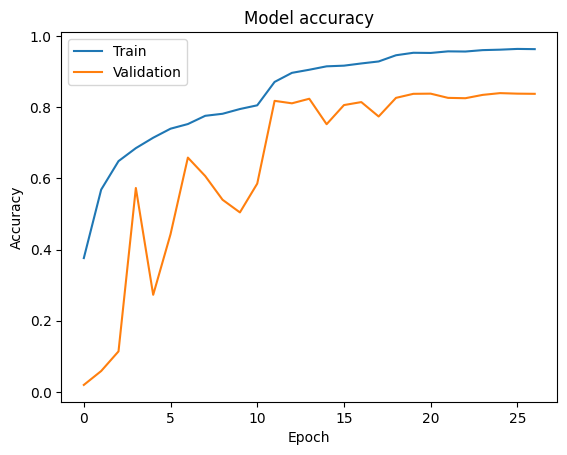

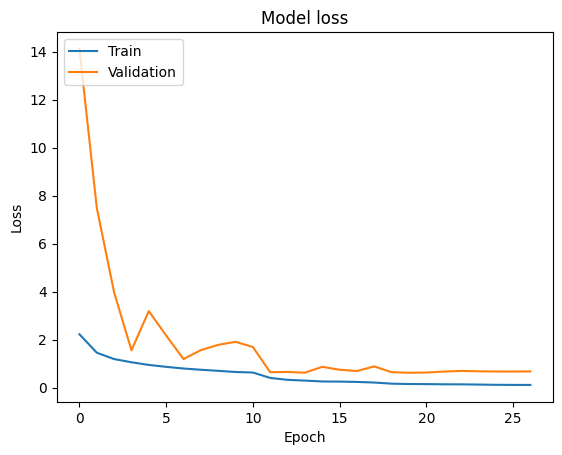

In [ ]:
history = model.fit(
    train_generator,
    epochs=300,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    shuffle=True)

# Plotting training and validation loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


FPN 83

In [ ]:
import tensorflow as tf

class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, target_size, **kwargs):
        super().__init__(**kwargs)
        self.target_size = target_size

    def call(self, inputs):
        return tf.image.resize(inputs, self.target_size, method=tf.image.ResizeMethod.BILINEAR)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], *self.target_size, input_shape[-1])

def get_backbone():
    base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=[224, 224, 3])
    layer_names = ['conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
    layers = [base_model.get_layer(name).output for name in layer_names]
    return tf.keras.Model(inputs=base_model.input, outputs=layers)

def build_fpn(feature_maps):
    # Set a common size for all feature maps before merging
    target_size = (32, 32)  # This size can be adjusted based on the actual sizes of your feature maps

    P5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(feature_maps[2])
    P5 = ResizeLayer(target_size)(P5)
    P5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(P5)

    P4 = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(feature_maps[1])
    P4 = tf.keras.layers.Add()([ResizeLayer(target_size)(P5), ResizeLayer(target_size)(P4)])
    P4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(P4)

    P3 = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(feature_maps[0])
    P3 = tf.keras.layers.Add()([ResizeLayer(target_size)(P4), ResizeLayer(target_size)(P3)])
    P3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(P3)

    return P3, P4, P5

def create_fpn_classification_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    backbone = get_backbone()
    feature_maps = backbone(inputs)

    fpn_outputs = build_fpn(feature_maps)
    concatenated_features = tf.keras.layers.Concatenate()(fpn_outputs)
    pooled_features = tf.keras.layers.GlobalAveragePooling2D()(concatenated_features)
    outputs = tf.keras.layers.Dense(30, activation='softmax')(pooled_features)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Build and summarize the model
model = create_fpn_classification_model()
model.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_17             │ [(None, 28, 28, 512),  │     23,587,712 │ input_layer_37[0][0]   │
│ (Functional)              │ (None, 14, 14, 1024),  │                │                        │
│                           │ (None, 7, 7, 2048)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 7, 7, 256)      │        524,544 │ functional_17[0][2]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_layer_9            │ (None, 32, 32, 256)    │              0 │ conv2d_29[0][0]        │
│ (ResizeLayer)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ resize_layer_9[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 14, 14, 256)    │        262,400 │ functional_17[0][1]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_layer_10           │ (None, 32, 32, 256)    │              0 │ conv2d_30[0][0]        │
│ (ResizeLayer)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_layer_11           │ (None, 32, 32, 256)    │              0 │ conv2d_31[0][0]        │
│ (ResizeLayer)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 32, 32, 256)    │              0 │ resize_layer_10[0][0], │
│                           │                        │                │ resize_layer_11[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 28, 28, 256)    │        131,328 │ functional_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_layer_12           │ (None, 32, 32, 256)    │              0 │ conv2d_32[0][0]        │
│ (ResizeLayer)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_layer_13           │ (None, 32, 32, 256)    │              0 │ conv2d_33[0][0]        │
│ (ResizeLayer)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 32, 32, 256)    │              0 │ resize_layer_12[0][0], │
│                           │                        │                │ resize_layer_13[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)   

 Total params: 26,299,294 (100.32 MB)

 Trainable params: 26,246,174 (100.12 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        F1Score()
])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

Epoch 1/300
252/252 ━━━━━━━━━━━━━━━━━━━━ 188s 510ms/step - accuracy: 0.1640 - f1_score: 0.0926 - loss: 5.9087 - precision: 0.2591 - recall: 0.0568 - val_accuracy: 0.0178 - val_f1_score: 0.0178 - val_loss: 6.2122 - val_precision: 0.0178 - val_recall: 0.0178 - learning_rate: 0.0010
Epoch 2/300
252/252 ━━━━━━━━━━━━━━━━━━━━ 99s 393ms/step - accuracy: 0.4183 - f1_score: 0.3481 - loss: 2.0059 - precision: 0.6295 - recall: 0.2411 - val_accuracy: 0.0178 - val_f1_score: 9.1115e-04 - val_loss: 4.7529 - val_precision: 0.0060 - val_recall: 4.9334e-04 - learning_rate: 0.0010
Epoch 3/300
252/252 ━━━━━━━━━━━━━━━━━━━━ 97s 384ms/step - accuracy: 0.4913 - f1_score: 0.4556 - loss: 1.7717 - precision: 0.6654 - recall: 0.3466 - val_accuracy: 0.0281 - val_f1_score: 0.0236 - val_loss: 4.9817 - val_precision: 0.0259 - val_recall: 0.0217 - learning_rate: 0.0010
Epoch 4/300
252/252 ━━━━━━━━━━━━━━━━━━━━ 99s 391ms/step - accuracy: 0.5679 - f1_score: 0.5397 - loss: 1.5054 - precision: 0.7336 - recall: 0.4271 - val

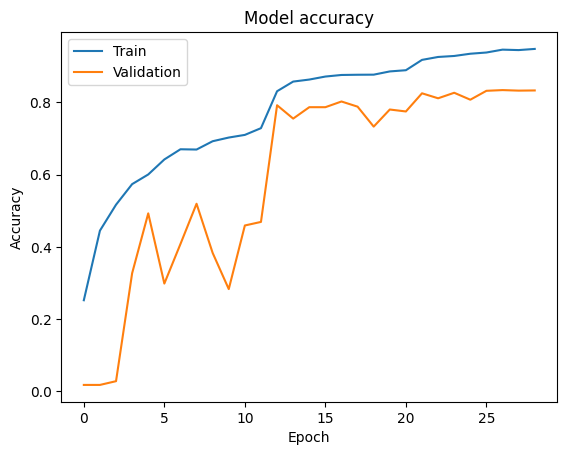

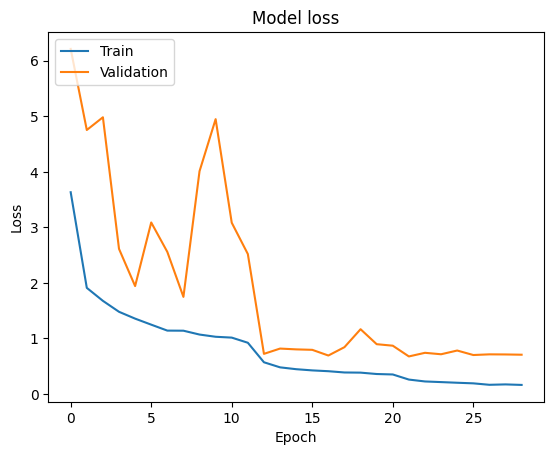

In [ ]:
history = model.fit(
    train_generator,
    epochs=300,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    shuffle=True)

# Plotting training and validation loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


3 layered model

In [ ]:
import tensorflow as tf
import numpy as np

def multi_input_dataset(generator, num_inputs):
    """
    Converts an ImageDataGenerator into a tf.data.Dataset that supports multiple inputs.

    Args:
    - generator: The ImageDataGenerator that yields (images, labels).
    - num_inputs: Number of model inputs.

    Returns:
    - A tf.data.Dataset that provides multiple inputs.
    """

    def _generator():
        for batch_images, batch_labels in generator:
            # Duplicate input for all three branches
            yield [batch_images] * num_inputs, batch_labels

    # ✅ Correct way to get the number of classes
    num_classes = len(generator.class_indices)

    # Create dataset
    dataset = tf.data.Dataset.from_generator(
        _generator,
        output_signature=(
            [tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)] * num_inputs,
            tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)  # ✅ Uses `len(generator.class_indices)`
        )
    )

    return dataset


In [ ]:
def prepare_multi_input(image, label):
    # Duplicate the same image for each branch
    return (image, image, image), label

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_multi_input = train_dataset.map(prepare_multi_input).batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_multi_input = val_dataset.map(prepare_multi_input).batch(64).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_multi_input = None
val_multi_input = None

In [ ]:
# Get input shape dynamically
input_shape = (224, 224, 3)  # Ensure correct shape
num_classes = y_train.shape[-1]

# Define dataset correctly
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(x_train, y_train),
    output_signature=(
        (tf.TensorSpec(shape=input_shape, dtype=tf.float32),  # Input 1
         tf.TensorSpec(shape=input_shape, dtype=tf.float32),  # Input 2
         tf.TensorSpec(shape=input_shape, dtype=tf.float32)),  # Input 3
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)  # Labels
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(x_test, y_test),
    output_signature=(
        (tf.TensorSpec(shape=input_shape, dtype=tf.float32),  # Input 1
         tf.TensorSpec(shape=input_shape, dtype=tf.float32),  # Input 2
         tf.TensorSpec(shape=input_shape, dtype=tf.float32)),  # Input 3
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)  # Labels
    )
)

# Batch and optimize performance
train_multi_input = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
val_multi_input = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)


In [ ]:
for images, labels in train_multi_input.take(1):
    print(f"Texture Input Shape: {images[0].shape}")  # Should be (batch_size, 224, 224, 3)
    print(f"Color Input Shape: {images[1].shape}")    # Should be (batch_size, 224, 224, 3)
    print(f"Structure Input Shape: {images[2].shape}") # Should be (batch_size, 224, 224, 3)


Texture Input Shape: (64, 224, 224, 3)
Color Input Shape: (64, 224, 224, 3)
Structure Input Shape: (64, 224, 224, 3)


model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Save the best model based on validation loss
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)

# Callback List
callbacks = [early_stopping, reduce_lr, checkpoint]


In [ ]:
loss, accuracy, precision, recall, f1_score = model.evaluate(val_generator)
print(f'test Loss: {loss}, test Accuracy: {accuracy}')

In [ ]:
from transformers import TFAutoModel
import tensorflow as tf

/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, Concatenate, GlobalAveragePooling2D,
    Lambda, MultiHeadAttention
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4
from transformers import TFAutoModel, AutoConfig

# ✅ Enable Mixed Precision Training to Reduce Memory Usage
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ✅ Reduce batch size to avoid OOM errors
BATCH_SIZE = 2  # Reduce from 32 to prevent memory overflow

# ✅ Ensure TensorFlow runs functions in Eager Mode
tf.config.run_functions_eagerly(True)

# ============================
# Model Definition
# ============================

# Texture Branch: EfficientNetB4
texture_input = Input(shape=(224, 224, 3), name="texture_input")
texture_base = EfficientNetB4(include_top=False, weights="imagenet")(texture_input)
texture_x = GlobalAveragePooling2D(name="texture_gap")(texture_base)
texture_x = Dense(256, activation="relu", dtype=tf.float32, name="texture_dense")(texture_x)

# Color Branch: Vision Transformer (ViT)
color_input = Input(shape=(224, 224, 3), name="color_input")

# ✅ Fix: Load ViT with correct input configuration
vit_config = AutoConfig.from_pretrained("google/vit-base-patch16-224-in21k")
vit_config.num_channels = 3  # Ensure it expects RGB input

vit_model = TFAutoModel.from_pretrained("google/vit-base-patch16-224-in21k", config=vit_config)

# ✅ Fix: Transpose input from NHWC to NCHW format for ViT
color_input_transposed = Lambda(
    lambda x: tf.transpose(x, perm=[0, 3, 1, 2]),  # Convert NHWC → NCHW
    name="transpose_vit_input"
)(color_input)

# ✅ Enable Gradient Checkpointing to save memory
vit_model.gradient_checkpointing = True

color_features = Lambda(
    lambda x: tf.reshape(vit_model(x, training=False).pooler_output, (-1, 768)),
    output_shape=(768,),
    name="vit_features"
)(color_input_transposed)

color_x = Dense(256, activation="relu", dtype=tf.float32, name="color_dense")(color_features)

# Structure Branch: Swin Transformer
structure_input = Input(shape=(224, 224, 3), name="structure_input")

# ✅ Fix: Load Swin Transformer with correct configuration
swin_config = AutoConfig.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
swin_config.num_channels = 3  # Ensure it expects RGB input

swin_model = TFAutoModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224", config=swin_config)

# ✅ Enable Gradient Checkpointing for Swin Transformer
swin_model.gradient_checkpointing = True

# ✅ Fix: Transpose input from NHWC to NCHW format for Swin Transformer
structure_input_transposed = Lambda(
    lambda x: tf.transpose(x, perm=[0, 3, 1, 2]),  # Convert NHWC → NCHW
    name="transpose_swin_input"
)(structure_input)

structure_features = Lambda(
    lambda x: tf.reshape(swin_model(x, training=False).pooler_output, (-1, 768)),
    output_shape=(768,),
    name="swin_features"
)(structure_input_transposed)

structure_x = Dense(256, activation="relu", dtype=tf.float32, name="structure_dense")(structure_features)

# Fusion Block: Multi-Head Attention
combined_features = Concatenate(name="combined_features")([texture_x, color_x, structure_x])
expanded_features = Lambda(lambda x: tf.expand_dims(x, axis=1),
                           output_shape=lambda s: (s[0], 1, s[1]),
                           name="expand_dims")(combined_features)

attention_features = MultiHeadAttention(num_heads=4, key_dim=192, dtype=tf.float32, name="multi_head_attention")(
    query=expanded_features,
    value=expanded_features,
    key=expanded_features
)

squeezed_features = Lambda(lambda x: tf.squeeze(x, axis=1),
                           output_shape=lambda s: (s[0], s[-1]),
                           name="squeeze_dims")(attention_features)

fusion_output = squeezed_features

# Classification Head
x = Flatten(name="flatten")(fusion_output)
x = Dropout(0.4, name="dropout_1")(x)
x = Dense(256, activation="relu", dtype=tf.float32, name="dense_1")(x)
x = Dropout(0.2, name="dropout_2")(x)
output = Dense(30, activation="softmax", dtype=tf.float32, name="predictions")(x)

# Build & Compile Model
model = Model(inputs=[texture_input, color_input, structure_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Print Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFSwinModel

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ color_input (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ structure_input           │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ texture_input             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 224, 224, 3)    │              0 │ color_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_4 (Cast)             │ (None, 224, 224, 3)    │              0 │ structure_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb4            │ (None, 7, 7, 1792)     │     17,673,823 │ texture_input[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transpose_vit_input       │ (None, 3, 224, 224)    │              0 │ cast_2[0][0]           │
│ (Lambda)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transpose_swin_input      │ (None, 3, 224, 224)    │              0 │ cast_4[0][0]           │
│ (Lambda)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ texture_gap               │ (None, 1792)           │              0 │ efficientnetb4[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vit_features (Lambda)     │ (None, 768)            │              0 │ transpose_vit_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_features (Lambda)    │ (None, 768)            │              0 │ transpose_swin_input[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 1792)           │              0 │ texture_gap[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_3 (Cast)             │ (None, 768)            │              0 │ vit_features[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_5 (Cast)             │ (None, 768)            │              0 │ swin_features[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ texture_dense (Dense)     │ (None, 256)            │        459,008 │ cast_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ color_dense (Dense)       │ (None, 256)            │        196,864 │ cast_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ structure_dense (Dens

 Total params: 21,093,501 (80.47 MB)

 Trainable params: 20,968,294 (79.99 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [ ]:
history = model.fit(
    train_multi_input,
    validation_data=val_multi_input,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


NameError: name 'early_stopping' is not defined

In [ ]:
def prepare_multi_input(image, label):
    # Duplicate the same image for each branch
    return (image, image, image), label

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_multi_input = train_dataset.map(prepare_multi_input).batch(2).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_multi_input = val_dataset.map(prepare_multi_input).batch(2).prefetch(tf.data.AUTOTUNE)


In [ ]:
import gc
import tensorflow as tf
from numba import cuda

# Clear Keras session
tf.keras.backend.clear_session()

# Garbage collect
gc.collect()

# Reset CUDA memory
cuda.select_device(0)
cuda.close()


model using knowledge distillation

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Input

# Number of classes in your dataset
num_classes = 30  # Adjust this to your number of classes

# Load pre-trained EfficientNetB7 as student, without the top layer
base_student_model = EfficientNetB7(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Adding custom Top layers
x = GlobalAveragePooling2D()(base_student_model.output)
output = Dense(num_classes, activation='softmax')(x)
student_model = Model(inputs=base_student_model.input, outputs=output)

# Set the base model's layers to be trainable
for layer in base_student_model.layers:
    layer.trainable = True


In [ ]:
teacher_model_url = "https://tfhub.dev/google/vit-base/patch16/224/2"  # Placeholder URL
teacher_model = tf.keras.Sequential([
    KerasLayer(teacher_model_url, trainable=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
teacher_model.build([None, 224, 224, 3])

OSError: https://tfhub.dev/google/vit-base/patch16/224/2 does not appear to be a valid module.

In [ ]:
import torch
from torchvision import datasets, transforms

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for your dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset (modify with your actual dataset)
dataset = datasets.ImageFolder(root='path_to_your_dataset', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Example models setup
teacher_model.to(device)
student_model.to(device)


NameError: name 'dataloader' is not defined